In [1]:
import os
import random
import shutil

# Paths to your dataset directories
data_dir = "/kaggle/input/deepfake-and-real-images/Dataset"  # Update with your dataset directory path
train_real_dir = os.path.join(data_dir, "Train", "Real")
train_fake_dir = os.path.join(data_dir, "Train", "Fake")
val_real_dir = os.path.join(data_dir, "Validation", "Real")
val_fake_dir = os.path.join(data_dir, "Validation", "Fake")

# Define target directories for the reduced dataset
reduced_data_dir = "/kaggle/working/reduced_dataset"
reduced_train_real_dir = os.path.join(reduced_data_dir, "train", "real")
reduced_train_fake_dir = os.path.join(reduced_data_dir, "train", "fake")
reduced_val_real_dir = os.path.join(reduced_data_dir, "validation", "real")
reduced_val_fake_dir = os.path.join(reduced_data_dir, "validation", "fake")

# Create target directories if they don't exist
os.makedirs(reduced_train_real_dir, exist_ok=True)
os.makedirs(reduced_train_fake_dir, exist_ok=True)
os.makedirs(reduced_val_real_dir, exist_ok=True)
os.makedirs(reduced_val_fake_dir, exist_ok=True)

# Set desired number of images
train_size_real, train_size_fake = 17500, 17500
val_size_real, val_size_fake = 7500, 7500

# Helper function to sample and copy images
def sample_and_copy(src_dir, dest_dir, sample_size):
    images = os.listdir(src_dir)
    sampled_images = random.sample(images, sample_size)
    for img in sampled_images:
        shutil.copy(os.path.join(src_dir, img), dest_dir)

# Sample images for training and validation
sample_and_copy(train_real_dir, reduced_train_real_dir, train_size_real)
sample_and_copy(train_fake_dir, reduced_train_fake_dir, train_size_fake)
sample_and_copy(val_real_dir, reduced_val_real_dir, val_size_real)
sample_and_copy(val_fake_dir, reduced_val_fake_dir, val_size_fake)

print("Dataset reduced and copied successfully!")

Dataset reduced and copied successfully!


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
IMG_SIZE = (299, 299)
BATCH_SIZE = 32

# Define paths for training and validation datasets
train_data_dir = '/kaggle/working/reduced_dataset/train'  # replace with your training data path
validation_data_dir = '/kaggle/working/reduced_dataset/validation'  # replace with your validation data path

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)  # Normalization only
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'  # For binary classification
)

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 35000 images belonging to 2 classes.
Found 15000 images belonging to 2 classes.


In [5]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load Xception model without the top layer (for transfer learning)
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model
base_model.trainable = False

# Add new classification layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary output
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


In [3]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop after 5 epochs with no improvement
    restore_best_weights=True  # Restore the best weights at the end
)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # Set to a high number; early stopping will end training earlier if needed
    callbacks=[early_stopping]
)

In [6]:
# Unfreeze the last 20 layers of the base model for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Adjust this number if needed
    layer.trainable = False

In [7]:
from tensorflow.keras.optimizers import Adam

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])


In [8]:
# Retrain the model with fine-tuning
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # Set high; early stopping will stop if no improvement
    callbacks=[early_stopping]
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730446078.242651     112 service.cc:145] XLA service 0x7f3b74002c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730446078.242707     112 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730446078.242711     112 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1730446101.815722     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 442s 376ms/step - accuracy: 0.7258 - loss: 0.5345 - val_accuracy: 0.8468 - val_loss: 0.3418
Epoch 2/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 392s 358ms/step - accuracy: 0.8986 - loss: 0.2410 - val_accuracy: 0.8808 - val_loss: 0.2711
Epoch 3/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 393s 359ms/step - accuracy: 0.9289 - loss: 0.1753 - val_accuracy: 0.8999 - val_loss: 0.2383
Epoch 4/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 393s 359ms/step - accuracy: 0.9456 - loss: 0.1367 - val_accuracy: 0.9077 - val_loss: 0.2215
Epoch 5/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 393s 359ms/step - accuracy: 0.9566 - loss: 0.1066 - val_accuracy: 0.9135 - val_loss: 0.2123
Epoch 6/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 393s 359ms/step - accuracy: 0.9644 - loss: 0.0898 - val_accuracy: 0.9225 - val_loss: 0.1945
Epoch 7/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 393s 358ms/step - accuracy: 0.9727 - loss: 0.0744 - val_accuracy: 0.9230 - val_loss: 0.2038
Epoch 8/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 392s 358ms/step - accuracy: 0.9

In [9]:
# Evaluate on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss after fine-tuning: {val_loss:.4f}, Validation Accuracy after fine-tuning: {val_accuracy:.4f}")

469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 207ms/step - accuracy: 0.9238 - loss: 0.1913
Validation Loss after fine-tuning: 0.1945, Validation Accuracy after fine-tuning: 0.9225


In [18]:
model.save("/kaggle/working/model_xception.keras")  # For SavedModel format

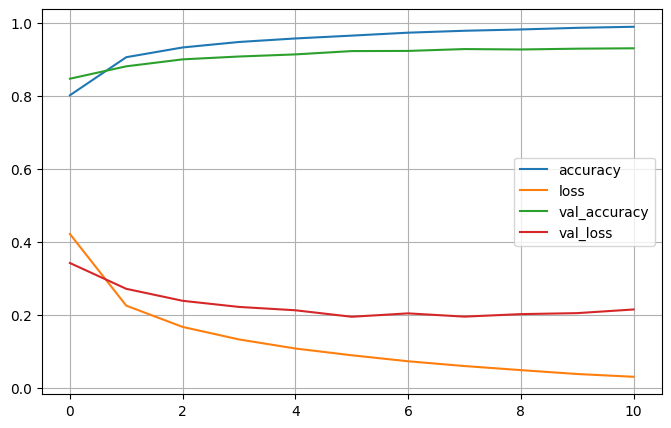

In [20]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to the test dataset
test_data_dir = "/kaggle/input/deepfake-and-real-images/Dataset/Test"

# ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling, no augmentation for testing

# Test data generator
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(299, 299),  # Use the same image size used for training
    batch_size=32,
    class_mode='binary',  # Since we have two classes: real and fake
    shuffle=False  # Shuffle should be False for evaluation
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Found 10905 images belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


341/341 ━━━━━━━━━━━━━━━━━━━━ 90s 265ms/step - accuracy: 0.8876 - loss: 0.2766
Test Loss: 0.4060, Test Accuracy: 0.8417


In [29]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Adjusted patience
    restore_best_weights=True
)

In [31]:
# Learning rate reduction callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

In [32]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,  # Increased number of epochs
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 415s 367ms/step - accuracy: 0.9219 - loss: 0.1859 - val_accuracy: 0.9185 - val_loss: 0.2332 - learning_rate: 1.0000e-05
Epoch 2/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 393s 359ms/step - accuracy: 0.9649 - loss: 0.0922 - val_accuracy: 0.9223 - val_loss: 0.2283 - learning_rate: 1.0000e-05
Epoch 3/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 443s 359ms/step - accuracy: 0.9744 - loss: 0.0665 - val_accuracy: 0.9215 - val_loss: 0.2454 - learning_rate: 1.0000e-05
Epoch 4/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 393s 359ms/step - accuracy: 0.9768 - loss: 0.0597 - val_accuracy: 0.9264 - val_loss: 0.2332 - learning_rate: 1.0000e-05
Epoch 5/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 393s 359ms/step - accuracy: 0.9830 - loss: 0.0435 - val_accuracy: 0.9287 - val_loss: 0.2318 - learning_rate: 1.0000e-05
Epoch 6/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 393s 359ms/step - accuracy: 0.9845 - loss: 0.0388 - val_accuracy: 0.9301 - val_loss: 0.2278 - learning_rate: 5.0000e-06
Epoch 7/50
1094/1094 ━━━━━━━

In [33]:
# Evaluate on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss after fine-tuning: {val_loss:.4f}, Validation Accuracy after fine-tuning: {val_accuracy:.4f}")

469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 207ms/step - accuracy: 0.9304 - loss: 0.2324
Validation Loss after fine-tuning: 0.2278, Validation Accuracy after fine-tuning: 0.9301


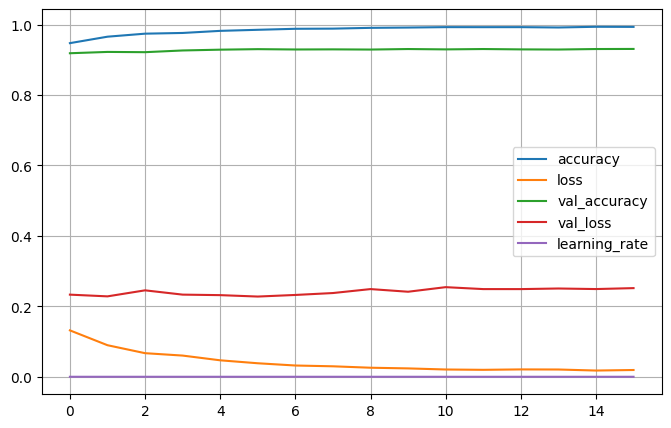

In [34]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [35]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

341/341 ━━━━━━━━━━━━━━━━━━━━ 72s 211ms/step - accuracy: 0.8972 - loss: 0.3661
Test Loss: 0.6401, Test Accuracy: 0.8341


341/341 ━━━━━━━━━━━━━━━━━━━━ 71s 209ms/step


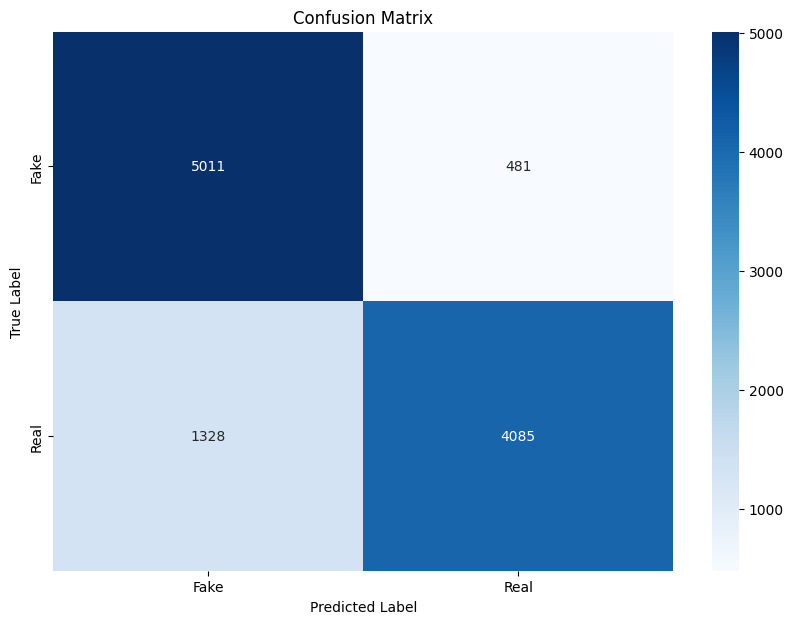

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32")  # Convert probabilities to binary labels

# Get true labels
true_classes = test_generator.classes  # True labels
class_labels = list(test_generator.class_indices.keys())  # Class labels: ['fake', 'real']

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [39]:
model.save("/kaggle/working/model_xception_2.keras")  # For SavedModel format